In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

%matplotlib inline

In [10]:
# Get data

data = pd.read_csv('747.csv')
start_time = 15.9531  # replace with obtained peak value from peaks code
end_time = 23.1638    # replace with obtained peak value from peaks code

filtered_data = data[(data['time (min)'] >= start_time) & (data['time (min)'] <= end_time)]

time = filtered_data['time (min)'].values

detector_voltages = filtered_data.filter(regex='detector voltage').values  # All detector voltage columns
num_detectors = detector_voltages.shape[1]

uv_absorbance_channel1 = filtered_data['UV absorbance data: absorbance  (AU) channel 1'].values
uv_absorbance_channel2 = filtered_data['UV absorbance data: absorbance  (AU) channel 2'].values

uv_absorbance = uv_absorbance_channel1 #can use channel 1 + channel 2 / 2 to get average if we want

print(f"Detector voltages shape: {detector_voltages.shape}")
print(f"UV absorbance shape: {uv_absorbance.shape}")



Detector voltages shape: (845, 17)
UV absorbance shape: (845,)


# Need Real values (especially standard voltage values for sample)

In [12]:
#calibration data

c_std = 1e-3 #in g/mL  #need real concentration

# Known Rayleigh ratio of the standard sample at each detector angle
# Assuming R_std is constant for all detectors for simplicity (in m^-1)
R_std = 1e-5  # Need actual 

# V_std = detector_voltages
V_std = np.linspace(0.5, 1.5, num_detectors)  # Simulated standard voltages
K_detector = R_std / V_std

for i in range(num_detectors):
    print(f"Detector {i+2}: K_detector = {K_detector[i]:.2e} m^-1/V")

# Compute Rtheta for each det and time point

R_theta = np.zeros_like(detector_voltages)
for i in range(num_detectors):
    R_theta[:, i] = K_detector[i] * detector_voltages[:, i]
    
print(f"R_theta shape: {R_theta.shape}")

Detector 2: K_detector = 2.00e-05 m^-1/V
Detector 3: K_detector = 1.78e-05 m^-1/V
Detector 4: K_detector = 1.60e-05 m^-1/V
Detector 5: K_detector = 1.45e-05 m^-1/V
Detector 6: K_detector = 1.33e-05 m^-1/V
Detector 7: K_detector = 1.23e-05 m^-1/V
Detector 8: K_detector = 1.14e-05 m^-1/V
Detector 9: K_detector = 1.07e-05 m^-1/V
Detector 10: K_detector = 1.00e-05 m^-1/V
Detector 11: K_detector = 9.41e-06 m^-1/V
Detector 12: K_detector = 8.89e-06 m^-1/V
Detector 13: K_detector = 8.42e-06 m^-1/V
Detector 14: K_detector = 8.00e-06 m^-1/V
Detector 15: K_detector = 7.62e-06 m^-1/V
Detector 16: K_detector = 7.27e-06 m^-1/V
Detector 17: K_detector = 6.96e-06 m^-1/V
Detector 18: K_detector = 6.67e-06 m^-1/V
R_theta shape: (845, 17)


In [13]:
# sample conc using uv data

epsilon = 1e5 #molar ext coeff (ε) in L·mol^-1·cm^-1

#path length in cm
path_length = 1.0

# molecular weight of sample if known
# ifunknown, initial assumption or iterative approach
#maybe machine learning??
Mw_approx = 1e5 #in g/mol

#calc conc 
epsilon_mL = epsilon / 1000 # Now in mL·mol^-1·cm^-1
c_mol_per_mL = uv_absorbance / (epsilon_mL * path_length)

#convert to g/mL
c = c_mol_per_mL * Mw_approx
print(f"Sample concentration (g/mL): {c[:5]}")

Sample concentration (g/mL): [41.222674 41.793538 42.362388 42.933609 43.516645]


In [14]:
# get optical constant
n = 1.33 #ref of water
NA = 6.02214076e23  
lambda_vac = 632.8e-9

dn_dc = 00.185 #need real
lambda_cm = lambda_vac * 100  # Convert from meters to cm
K = (4 * np.pi**2 * n**2 * (dn_dc)**2) / (NA * lambda_cm**4)

print(f"Optical constant K = {K:.2e} cm^2·mol·g^-2")

Optical constant K = 2.48e-07 cm^2·mol·g^-2


In [15]:
# calc molar mass
M_values = np.zeros_like(R_theta) #initialise to store M valeus
#avoid division by 0
c_safe = c + 1e-12
for i in range(num_detectors):
    M_values[:, i] = R_theta[:, i] / (K * c_safe)
    print(f"M_values shape: {M_values.shape}")
    
M_avg_detectors = np.mean(M_values, axis=0)
M_std_detectors = np.std(M_values, axis=0)

# Print the average Molar Mass for each detector
for i in range(num_detectors):
    print(f"Detector {i+2}: Average Molar Mass = {M_avg_detectors[i]:.2e} g/mol")

# Calculate the overall average Molar Mass
M_overall_avg = np.mean(M_avg_detectors)
M_overall_std = np.std(M_avg_detectors)

print(f"\nOverall Average Molar Mass: {M_overall_avg:.2e} ± {M_overall_std:.2e} g/mol")

M_values shape: (845, 17)
M_values shape: (845, 17)
M_values shape: (845, 17)
M_values shape: (845, 17)
M_values shape: (845, 17)
M_values shape: (845, 17)
M_values shape: (845, 17)
M_values shape: (845, 17)
M_values shape: (845, 17)
M_values shape: (845, 17)
M_values shape: (845, 17)
M_values shape: (845, 17)
M_values shape: (845, 17)
M_values shape: (845, 17)
M_values shape: (845, 17)
M_values shape: (845, 17)
M_values shape: (845, 17)
Detector 2: Average Molar Mass = 3.75e-01 g/mol
Detector 3: Average Molar Mass = 9.35e-02 g/mol
Detector 4: Average Molar Mass = 4.83e-02 g/mol
Detector 5: Average Molar Mass = 2.33e-02 g/mol
Detector 6: Average Molar Mass = 4.86e-02 g/mol
Detector 7: Average Molar Mass = 3.53e-02 g/mol
Detector 8: Average Molar Mass = 2.94e-02 g/mol
Detector 9: Average Molar Mass = 2.46e-02 g/mol
Detector 10: Average Molar Mass = 2.26e-02 g/mol
Detector 11: Average Molar Mass = 2.17e-02 g/mol
Detector 12: Average Molar Mass = 2.08e-02 g/mol
Detector 13: Average Molar 

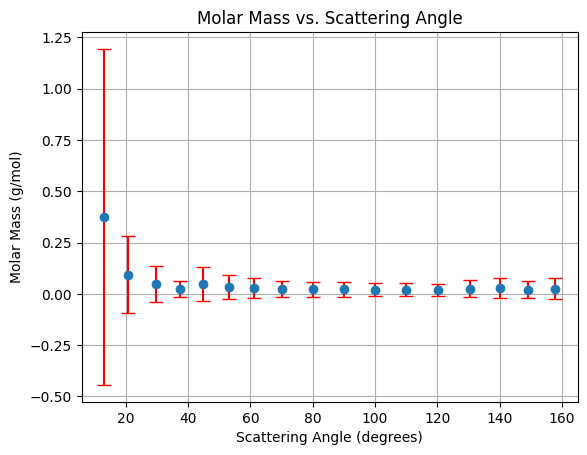

In [16]:
scattering_angles = np.array([13.07,20.68,29.62,37.48,44.84,53.07,61.08,70.07,80.06,90.00,99.94,109.93,120.06,130.43,140.03,149.02,157.70])
scattering_angles_rad = np.deg2rad(scattering_angles)

plt.errorbar(scattering_angles, M_avg_detectors, yerr=M_std_detectors, fmt='o', ecolor='r', capsize=5)
plt.xlabel('Scattering Angle (degrees)')
plt.ylabel('Molar Mass (g/mol)')
plt.title('Molar Mass vs. Scattering Angle')
plt.grid(True)
plt.show()